In [14]:
import os, sys, argparse, importlib, time, inspect
import numpy as np
import matplotlib.pyplot as plt
import os.path as osp
if hasattr(__builtins__,'__IPYTHON__'):
    print('Notebook')
    notebook=1
    from tqdm.notebook import tqdm
else:
    print('Not notebook')
    notebook=0
    from tqdm import tqdm
from tensorflow.keras import backend as K
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
import tensorflow_probability as tfp

gpu_devices = tf.config.list_physical_devices('GPU') 
if len(gpu_devices) > 0:
    print("GPU detected")
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('No GPU detected')

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import load_model, Model
import spektral
from sklearn.preprocessing import normalize
from spektral.data import DisjointLoader, BatchLoader, SingleLoader
from importlib import reload
if notebook:
    import winsound
import dill
import datetime as dt
import plotly

Notebook
GPU detected


In [15]:
#everything here could be JSON

################################################
# Setup Deafult Variables                       # 
################################################
learning_rate = 2.5e-4
warm_up       = 4
batch_size    = 512
epochs        = 20
n_data       = 1e5
scenario    = "stop_muon"
patience = 20

################################################
# Setup Model hyperparameters                  # 
################################################

# make in model

################################################
# Setup Other Hyperparameters                   # 
################################################


loss_method   = "von Mises"
n_neighbors   = 6 # SKRIV SELV IND
wandblog      = 0
opt = Adam(learning_rate)

if wandblog:
    import wandb
    !wandb login b5b917a9390932e56fccfcbff6f528ccd85c44bf
    #checks
    wandb.init(project="icecube", group=scenario,entity="chri862z")

    # Declare for log
    wandb.config.angleunit=angleunit
    wandb.config.hidden_states = hidden_states
    wandb.config.n_data = n_data
    wandb.config.forward = forward
    wandb.config.dropout = dropout
    wandb.config.learning_rate = learning_rate
    wandb.config.warm_up = warm_up
    wandb.config.batch_size = batch_size
    wandb.config.loss_func = loss_method
    wandb.config.n_neighbors = n_neighbors
    wandb.config.optimizer = 'Adam'
    wandb.run.name = wandb.run.id
    wandbname=wandb.run.id

In [16]:
################################################
# Load data                      # 
################################################

import dev.data_load as dl
reload(dl)
graph_data=dl.graph_data
dataset=graph_data(n_data=n_data, n_neighbors=n_neighbors, restart=0)
idx_lists = dataset.index_lists
# Split data
dataset_train = dataset[idx_lists[0]]
dataset_val   = dataset[idx_lists[1]]
dataset_test  = dataset[idx_lists[2]]
loader_train = DisjointLoader(dataset_train, epochs=epochs, batch_size=batch_size) # the different loaders work very very differently, beware
loader_test = DisjointLoader(dataset_test, batch_size=batch_size, epochs=1)
if notebook:
    winsound.Beep(400,300)

Not notebook
Loading data to memory






In [17]:
import dev.stopGCN as m
reload(m)
# model=m.GCN0(6)
model=m.stopGCN(n_out=1)

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score
def metrics(y_reco, y_true):
    FPR, TPR, _ = roc_curve(y_true, y_reco)
    AUC=roc_auc_score(y_true, y_reco)
    return FPR, TPR, AUC


In [19]:
def plot_roc(loader, save=False, save_path=''):
    '''Function to test and plot performance of Graph DL
    input should be dom pos x,y,z , time, charge(log10)
    target should be energy(log10),zenith angle, azimuthal angle, NOT unit vec 
    '''
    loss = 0
    prediction_list, target_list = [], []
    for batch in loader:
        inputs, targets = batch
        predictions, targets, out = test_step(inputs, targets)
        loss           += out
        
        prediction_list.append(predictions)
        target_list.append(targets)

    y_reco  = tf.concat(prediction_list, axis = 0).numpy()
    y_true  = tf.concat(target_list, axis = 0)
    y_true  = tf.cast(y_true, tf.float32).numpy()
    FPR, TPR, AUC = metrics(y_reco, y_true)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,7))
    ax[0].plot(FPR, TPR, label=f'ROC with AUC: {AUC}')
    ax[1].hist(y_reco, histtype='step', bins=100)
    if save:
        plt.savefig(save_path)

In [20]:
# ################################################
# # Setup functions                            # 
# ################################################
from tensorflow_addons.losses import SigmoidFocalCrossEntropy as loss_func
loss_func=loss_func()
import tensorflow.keras.losses as bc

loss_func=bc.BinaryCrossentropy(from_logits=False, label_smoothing=0, reduction=tf.keras.losses.Reduction.NONE)

def lr_schedule(epochs = epochs, initial = learning_rate, warm_up=warm_up, decay = 0.9):
    n = 1
    lr = initial
    yield lr
    while n < warm_up:
        lr *= 2
        n  += 1
        yield lr
    while True:
        lr *= decay
        n  += 1 
        yield lr


#make functions into tf functions

@tf.function(input_signature = loader_train.tf_signature(), experimental_relax_shapes = True)
def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training = True)
        targets     = tf.cast(targets, tf.float32)
        loss        = loss_func(targets, predictions)
        loss = tf.reduce_mean(loss)
        loss       += sum(model.losses)

    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

@tf.function(input_signature = loader_test.tf_signature(), experimental_relax_shapes = True)
def test_step(inputs, targets):
    predictions = model(inputs, training = False)
    targets     = tf.cast(targets, tf.float32) 
    
    loss       = loss_func(targets, predictions)
    out = tf.reduce_mean(loss)

    return predictions, targets, out


def validation(loader):
    loss = 0
    prediction_list, target_list = [], []
    for batch in loader:
        inputs, targets = batch
        predictions, targets, out = test_step(inputs, targets)
        loss           += out
        
        prediction_list.append(predictions)
        target_list.append(targets)
    
    y_reco  = tf.concat(prediction_list, axis = 0)
    y_true  = tf.concat(target_list, axis = 0)
    y_true  = tf.cast(y_true, tf.float32)
    
    _,_, auc= metrics(y_reco, y_true)
    
    return loss, auc

In [21]:
k=0
if notebook:
    k=0.2
tot_time=0
current_batch = 0
current_epoch = 1
loss          = 0
lowest_loss   = np.inf
early_stop    = 1
early_stop_counter    = 0
if notebook:
    pbar0          = tqdm(total = epochs, position = 0, leave = True)
    pbar0.set_description(f"Epochbar")
pbar          = tqdm(total = loader_train.steps_per_epoch, position = k, leave = True)
start_time    = time.time()
lr_gen        = lr_schedule(initial=learning_rate)
learning_Rate = next(lr_gen)
cwd = osp.abspath('')
save_path = osp.join(cwd, 'trained_models/'+scenario)
if not osp.isdir(save_path):
    os.makedirs(save_path)
    print('New folder for saving '+scenario+' made')
# Implement saving model archictecture to wandb
if wandblog:
    save_path = osp.join(save_path, wandbname)
if not osp.isdir(save_path):
    os.makedirs(save_path)
    print('New folder for saving run '+wandbname)
summarylist=[]
for batch in loader_train:
    inputs, targets = batch
    out             = train_step(inputs, targets)
    loss           += out
    if current_epoch==1 and current_batch==0:
        model.summary()
        if wandblog:
            summary=model.summary(print_fn=summarylist.append)
            table=wandb.Table(columns=["Layers"])
            for s in summarylist:
                table.add_data(s)
            wandb.log({'Model summary': table})
            n_params=np.sum([np.prod(v.get_shape()) for v in model.variables])
            wandb.config['n_params']=n_params
    current_batch  += 1
    pbar.update(1)
    pbar.set_description(f"Epoch {current_epoch} / {epochs}; Avg_loss: {loss / current_batch:.6f}")
    
    
    if current_batch == loader_train.steps_per_epoch:
        t=time.time() - start_time
        tot_time+=t
        print(f"Epoch {current_epoch} of {epochs} done in {t:.2f} seconds using learning rate: {learning_rate:.2E}")
        print(f"Avg loss of train: {loss / loader_train.steps_per_epoch:.6f}")

        loader_val    = DisjointLoader(dataset_val, epochs = 1,      batch_size = batch_size)
        val_loss, auc = validation(loader_val)
#         val_loss, val_metric = validation(loader_val)
        if wandblog:
            wandb.log({"Train Loss":      loss / loader_train.steps_per_epoch,
                       "Val loss": val_loss,
                      'AUC': auc})
        print(f"Avg loss of validation: {val_loss:.6f}")
        print(f"AUC: {auc}")
        if val_loss < lowest_loss:
            early_stop_counter = 0
            lowest_loss        = val_loss
        else:
            early_stop_counter += 1
        print(f'Early stop counter: {early_stop_counter}/{patience}, lowest val loss was {lowest_loss:.6f}')
        if early_stop and (early_stop_counter >= patience):
            model.save(save_path)
            print(f"Stopped training. No improvement was seen in {patience} epochs")
            break

        if current_epoch != epochs:
            pbar          = tqdm(total = loader_train.steps_per_epoch, position = k, leave = True)

        learning_rate = next(lr_gen)
        opt.learning_rate.assign(learning_rate)
        if notebook:
            pbar0.update(1)
        time_avg=tot_time/current_epoch
        delta=dt.timedelta(seconds=time_avg*(epochs-current_epoch))
        now = dt.datetime.now()
        then=now+delta
        time_e = then.strftime("%H:%M:%S")
        if notebook:
            pbar0.set_description(f"Expect to finish at {time_e}")
        if current_epoch % patience == 0:
            model.save(save_path)
            print("Model saved")
            if wandblog:
                loader_test = DisjointLoader(dataset_test, batch_size=batch_size, epochs=1)
                fig, ax = performance_e_alpha(loader_test, save=True, save_path=save_path)
                title="Metricsplot_"+str(current_epoch)
                wandb.log({title: [wandb.Image(fig, caption=title)]})
    
        loss            = 0
        start_time      = time.time()
        current_epoch  += 1
        current_batch   = 0
if wandblog:
    run.finish()        
if notebook:
    winsound.Beep(400,300)

Model: "stop_gcn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ecc_conv_1 (ECCConv)         multiple                  33984     
_________________________________________________________________
gcn_conv_2 (GCNConv)         multiple                  4096      
_________________________________________________________________
gcn_conv_3 (GCNConv)         multiple                  8192      
_________________________________________________________________
global_max_pool_1 (GlobalMax multiple                  0         
_________________________________________________________________
global_avg_pool_1 (GlobalAvg multiple                  0         
_________________________________________________________________
global_sum_pool_1 (GlobalSum multiple                  0         
_________________________________________________________________
dense_3 (Dense)              multiple                  2

Epoch 2 of 20 done in 118.57 seconds using learning rate: 5.00E-04
Avg loss of train: 3.602510
Avg loss of validation: 29.050312
AUC: 0.6858454472934472
Early stop counter: 0/20, lowest val loss was 29.050312


Epoch 3 of 20 done in 135.83 seconds using learning rate: 1.00E-03
Avg loss of train: 2.904541
Avg loss of validation: 64.788528
AUC: 0.7490005698005698
Early stop counter: 1/20, lowest val loss was 29.050312


Epoch 4 of 20 done in 133.47 seconds using learning rate: 2.00E-03
Avg loss of train: 2.733987


KeyboardInterrupt: 

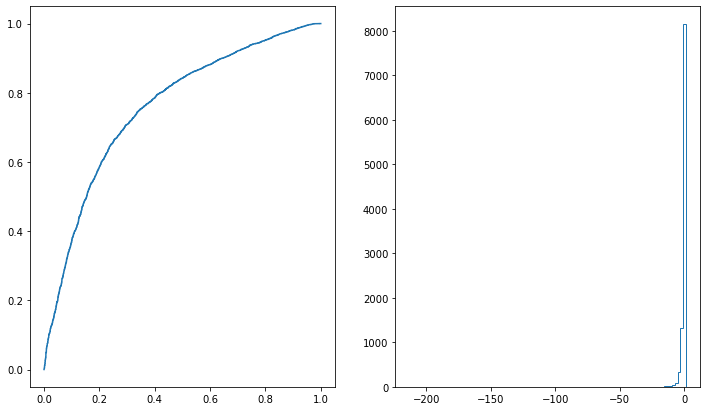

In [22]:
loader = DisjointLoader(dataset_test, batch_size=batch_size, epochs=1)
plot_roc(loader)

In [23]:
loader = DisjointLoader(dataset_test, batch_size=batch_size, epochs=1)
prediction_list, target_list = [], []
for batch in loader:
    inputs, targets = batch
    predictions, targets, out = test_step(inputs, targets)
    loss           += out

    prediction_list.append(predictions)
    target_list.append(targets)

y_reco  = tf.concat(prediction_list, axis = 0)
y_true  = tf.concat(target_list, axis = 0)
y_true  = tf.cast(y_true, tf.float32)

(array([[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 array([-213.14893  , -191.70007  , -170.25124  , -148.80238  ,
        -127.35353  , -105.904686 ,  -84.45583  ,  -63.00699  ,
         -41.55814  ,  -20.109291 ,    1.3395581], dtype=float32),
 <a list of 10000 BarContainer objects>)

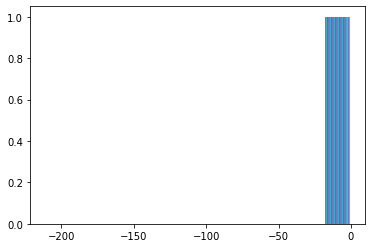

In [24]:
plt.hist(y_reco)

In [ ]:
k=1
# mask=np.abs(y_reco[:,k]-y_true[:,k])>np.pi
# mask=y_reco[:,k]<0

plt.hist(y_reco[:,k]%(np.pi/2), bins=50, alpha=0.4);
# plt.hist(np.abs(y_reco[:,2])-y_true[:,2], bins=50, alpha=0.4);
# plt.hist(np.abs(y_reco[:,k]), bins=50, alpha=0.4);
plt.hist(np.abs(y_true[:,k]), bins=50, alpha=0.4);

In [ ]:
fig3, ax3 = plt.subplots()
ax3.hist2d(y_true[:,k], y_reco[:,k]%(np.pi/2), bins=100, range=[np.percentile(y_reco[:,k]%(np.pi/2),[1,99]),[0,2]]);

In [ ]:
def test(loader):
    loss = 0
    prediction_list, target_list = [], []
    for batch in loader:
        inputs, targets = batch
        inputs[0][:, :3] = inputs[0][:, :3] / 1000
        predictions, targets, out = test_step(inputs, targets)
        loss           += out
        
        prediction_list.append(predictions)
        target_list.append(targets)

    y_reco  = tf.concat(prediction_list, axis = 0).numpy()
    y_true  = tf.concat(target_list, axis = 0)
    y_true  = tf.cast(y_true, tf.float32).numpy()


#     # Unit vects to angles
#     reco_vects = normalize(y_reco[:, 1:])    
#     true_vects = normalize(y_true[:, 1:])


#     reco_azi   = np.arctan2(reco_vects[:, 1], reco_vects[:, 0])
#     reco_zen   = np.arctan2(reco_vects[:, 2], np.sqrt((reco_vects[:, :2] ** 2).sum(1)))

#     true_azi   = np.arctan2(true_vects[:, 1], true_vects[:, 0])
#     true_zen   = np.arctan2(true_vects[:, 2], np.sqrt((true_vects[:, :2] ** 2).sum(1)))





    energy = y_true[:, 0]
    counts, bins = np.histogram(energy, bins = 10)

    xs = (bins[1:] + bins[: -1]) / 2

    w_energies, u_angles = [], []

    for i in range(len(bins)-1):
        idx = np.logical_and(energy > bins[i], energy < bins[i + 1])

        w, u_angle = metrics(y_true[idx, :], y_reco[idx, :])

        w_energies.append(w)
        u_angles.append(u_angle)


    fig, ax = plt.subplots(ncols = 3, nrows = 3, figsize = (12, 12))

    for a in ax[0]:
        a_ = a.twinx()
        a_.step(xs, counts, color = "gray", zorder = 10, alpha = 0.7, where = "mid")
        a_.set_yscale("log")
        a.set_xlabel("Log Energy")
    
    ax_top = ax[0]

    # Energy reconstruction
    ax_top[0].scatter(xs, w_energies)
    ax_top[0].set_title("Energy Performance")
    ax_top[0].set_ylabel(r"$w(\Delta log(E)$")


    # Angle reconstruction
    ax_top[1].scatter(xs, u_angles)
    ax_top[1].set_title("Angle Performance")
    ax_top[1].set_ylabel(r"$u(\Delta \Omega)$")


    # truth - pred plots
    ax_mid = ax[1]

    # Energy
    ax_mid[0].set_title("Energy")
    ax_mid[0].plot(y_true[:, 0], y_reco[:, 0], 'b.', alpha = 0.25)


    # Zenith
    ax_mid[1].set_title("Zenith angle")
    ax_mid[1].plot(true_zen, reco_zen, 'b.', alpha = 0.25)
    

    # Azimuthal
    ax_mid[2].set_title("Azimuthal angle")
    ax_mid[2].plot(true_azi, reco_azi, 'b.', alpha = 0.25)





    # Histogram of guesses
    ax_bot = ax[2]

    # Energy
    ax_bot[0].set_title("Energy")
    ax_bot[0].hist(y_reco[:, 0] - y_true[:, 0], label = "reco - true", histtype = "step", bins = 50)
    ax_bot[0].hist(y_reco[:, 0], label = "reco", histtype = "step", bins = 50)
    ax_bot[0].hist(y_true[:, 0], label = "true", histtype = "step", bins = 50)

    # Zenith
    ax_bot[1].set_title("Zenith angle")
    ax_bot[1].hist(reco_zen - true_zen, label = "reco - true", histtype = "step", bins = 50)
    ax_bot[1].hist(reco_zen, label = "reco", histtype = "step", bins = 50)
    ax_bot[1].hist(true_zen, label = "true", histtype = "step", bins = 50)

    # Azimuthal
    ax_bot[2].set_title("Azimuthal angle")
    ax_bot[2].hist(reco_azi - true_azi, label = "reco - true", histtype = "step", bins = 50)
    ax_bot[2].hist(reco_azi, label = "reco", histtype = "step", bins = 50)
    ax_bot[2].hist(true_azi, label = "true", histtype = "step", bins = 50)
    ax_bot[2].legend()

    fig.tight_layout()

    return fig, ax

In [ ]:
test(loader_test)